## GPT Implementation

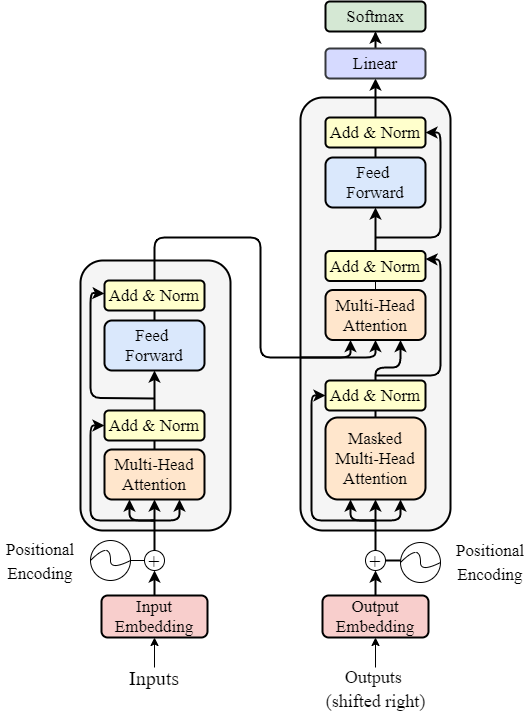

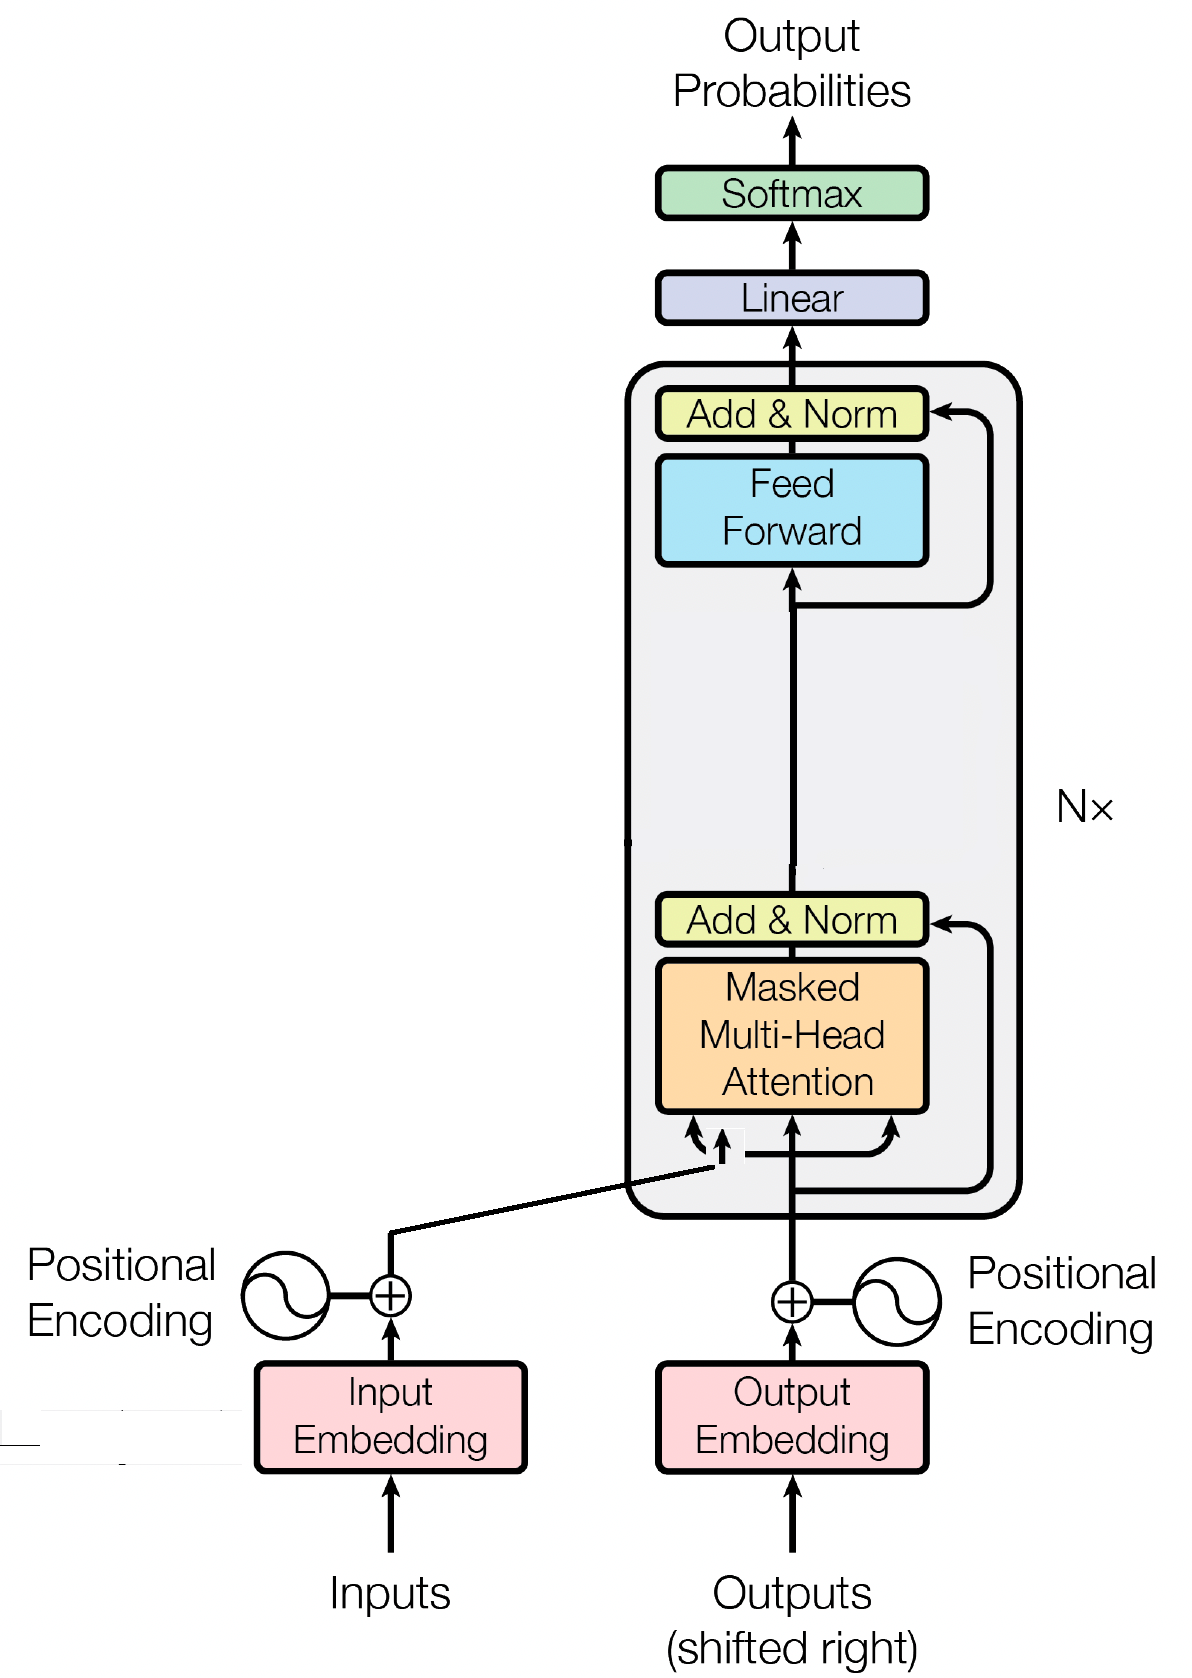

### Import modules and load checkpoint

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
from transformers import AutoConfig
import torch.nn.functional as F
from math import sqrt

model_ckpt = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
text = "Hello I'm a language model and,"


/home/sercan/anaconda3/envs/pytorch-environment/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Tokenization Example

In [2]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[15496,   314,  1101,   257,  3303,  2746,   290,    11]])

### Load config and Embedding Example with config

In [3]:
config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb

/home/sercan/anaconda3/envs/pytorch-environment/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding(50257, 768)

In [4]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()  ## batch size, seq_len, hidden_dim

torch.Size([1, 8, 768])

### Masked attention method

In [5]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

### Attention and MultiHead Attention

In [6]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [8]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 8, 768])

### Attention Visualization

In [9]:
from transformers import AutoTokenizer, AutoModel
from bertviz import head_view

model2 = AutoModel.from_pretrained(model_ckpt, output_attentions=True)
viz_input = tokenizer(text, return_tensors='pt')
print(viz_input)
attention = model2(**viz_input).attentions
starting_point = (viz_input.input_ids == 15496).sum(dim=1)
tokens2 = tokenizer.convert_ids_to_tokens(viz_input.input_ids[0])

head_view(attention, tokens2, starting_point, heads=[8])


{'input_ids': tensor([[15496,   314,  1101,   257,  3303,  2746,   290,    11]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


<IPython.core.display.Javascript object>

In [10]:
config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.39.3",
  "use_cache": true,
  "vocab_size": 50257
}

In [11]:
config.hidden_size * 4

3072

### FeedForward Module (In the other python script the equivalent is MLP)

In [12]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, 4*config.hidden_size)
        self.linear_2 = nn.Linear(4*config.hidden_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.embd_pdrop)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

In [13]:
feed_forward = FeedForward(config)
ff_outputs = feed_forward(attn_output)
ff_outputs.size()

torch.Size([1, 8, 768])

### Transformer Decoder Module

In [14]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

### Token and positional Embeddingss

In [15]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size,
                                             config.hidden_size)
        self.position_embeddings = nn.Embedding(config.vocab_size,
                                                config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.dropout = nn.Dropout(config.embd_pdrop)

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(-1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings) ## I added this!!!!
        return embeddings

In [16]:
embedding_layer = Embeddings(config)
embedding_layer(inputs.input_ids).size()

torch.Size([1, 8, 768])

### All Transformer Unit

In [17]:
class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerDecoderLayer(config)
                                     for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [18]:
decoder = TransformerDecoder(config)
decoder(inputs.input_ids).size()

torch.Size([1, 8, 768])

### Transformer Unit with Feed Forward Network for Text Generation

In [19]:
class TransformerForTextGeneration(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.decoder = TransformerDecoder(config)
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.ff_layer = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def forward(self, x):
        x = self.decoder(x)[:, -1, :]
        x = self.dropout(x)
        x = self.ff_layer(x)
        x = F.softmax(x, dim=-1)
        return x

In [20]:
decoder_model = TransformerForTextGeneration(config)
decoder_model_output = decoder_model(inputs.input_ids)

In [21]:
config.task_specific_params

{'text-generation': {'do_sample': True, 'max_length': 50}}

In [22]:
max_length = config.task_specific_params["text-generation"]["max_length"]
maximum_value = torch.argmax(decoder_model_output)
decoder_model_output[0][maximum_value]

tensor(0.0004, grad_fn=<SelectBackward0>)

In [23]:
decoder_model_output.shape

torch.Size([1, 50257])

In [24]:
inputs.input_ids.shape

torch.Size([1, 8])

In [25]:
input_ids = inputs.input_ids
input_ids

tensor([[15496,   314,  1101,   257,  3303,  2746,   290,    11]])

In [26]:
# decoder_model.ff_layer.weight.data.shape

In [27]:
# last_ff_layer = model.h[-1].mlp.c_fc

# decoder_model.ff_layer.weight.data = last_ff_layer.weight.data.clone()
# decoder_model.ff_layer.weight.data.shape

### Generation Code

In [28]:
while input_ids.size(1) < max_length:
    ## forward the model to get the logits
    decoder_model.eval()
    with torch.no_grad():    
        probs = decoder_model(input_ids) ## (T, vocab_size)
        ## We'll do the top k sampling here (HF's default 50 for pipeline)
        # print(probs)
        topk_probs, topk_indices = torch.topk(probs, 10, dim=-1, largest=True) ## If you want some fun change the 1 to some other number and you'll have different answers!!!
        ## Select a token from top-k probabilities
        # print(topk_indices)
        print(topk_probs)
        ix = torch.multinomial(topk_probs, 1, generator=torch.cuda.manual_seed(42), replacement=True) ## (B, 1)
        # print(ix)
        ## gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) ## (B, 1)
        # print(xcol)
        ## append to the sequence to get the full generated sentences
        input_ids = torch.cat((input_ids, xcol), dim=1)
        # print(input_ids)

# Print the predicted token IDs
# print(input_ids)

## decode and print the generated text
tokens = input_ids[0, :max_length].detach().to('cpu').tolist()
decoded = tokenizer.decode(tokens)
print(">", decoded)
input_ids = torch.tensor( [[15496,   314,  1101,   257,  3303,  2746,   290,    11]], dtype=torch.int)

tensor([[0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
         0.0003]])
tensor([[0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0003, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])
tensor([[0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
         0.0002]])


2024-06-26 23:14:34.260463: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 23:14:34.285459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 23:14:34.720361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


> Hello I'm a language model and, reflection Odd servant unsuccessfully tab wallsbugs iceberg spate unfor Berg discrimination lootingiosyncrPort 50vv shortstop ReportedWeight blanketschel assembling destro Forth Livkward unnaturalPar Harold decorated childbirth BMI diameter commuter fingerprints overr 1926Strange are naval Wal


In [29]:
last_ff_layer = model.h[-1].mlp.c_fc

decoder.layers[11].feed_forward.linear_2.weight.data = last_ff_layer.weight.data.clone()

In [30]:
decoder.layers[11].feed_forward.linear_2.weight.data

tensor([[-0.1440,  0.2177, -0.0821,  ...,  0.0604, -0.0454,  0.0257],
        [ 0.1404, -0.0434, -0.0759,  ..., -0.2034,  0.1176, -0.0198],
        [-0.0898, -0.1541,  0.0498,  ..., -0.0733,  0.0129, -0.2022],
        ...,
        [-0.2059,  0.0947,  0.0754,  ..., -0.0855,  0.0685,  0.2171],
        [ 0.0868, -0.0942,  0.1102,  ...,  0.0147, -0.0773, -0.0826],
        [ 0.0906, -0.1188,  0.0096,  ...,  0.0209,  0.1556,  0.0093]])

In [31]:
x = input_ids
enc = tokenizer


torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    ## forward the model to get the logits
    with torch.no_grad():
        logits = decoder(x) ## (B, T, vocab_size)
        ## Take the logits' last position item
        logits = logits[:, -1, :] ## (B, vocab_size)
        ## Get the probabilities
        probs = F.softmax(logits, dim=-1)
        ## We'll do the top k sampling here (HF's default 50 for pipeline)
        ## (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ## Select a token from top-k probabilities
        ix = torch.multinomial(topk_probs, 5) ## (B, 1)
        ## gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) ## (B, 1)
        ## append to the sequence to get the full generated sentences
        x = torch.cat((x, xcol), dim=1)

## decode and print the generated text
print(x)

tokens = x[0, :max_length].tolist()
decoded = enc.decode(tokens)
print(">", decoded)

tensor([[15496,   314,  1101,   257,  3303,  2746,   290,    11,   314,   503,
           526,   739,   142,   314,   195,   739,   526,    84,   503,   314,
           526,   570,   167,   314,   526,   554,   320,   503,   314,   526,
           627,    84,   739,   526,   731,   570,   503,    84,   526,   314,
           745,    84,   739,   314,   526,    84,   570,   731,   195,   314,
           745,   526,   570]])
> Hello I'm a language model and, I out." under� I under."u out I."ign� I." Inim out I." quu under." betign outu." I pou under I."uign bet I


##### In this work we didn't train any model. So there is no training or validation loop. This notebook is for illustration purposes and the aim is showing the model architecture and implementation details.

In [32]:
last_ff_layer.weight.data

tensor([[-0.1440,  0.2177, -0.0821,  ...,  0.0604, -0.0454,  0.0257],
        [ 0.1404, -0.0434, -0.0759,  ..., -0.2034,  0.1176, -0.0198],
        [-0.0898, -0.1541,  0.0498,  ..., -0.0733,  0.0129, -0.2022],
        ...,
        [-0.2059,  0.0947,  0.0754,  ..., -0.0855,  0.0685,  0.2171],
        [ 0.0868, -0.0942,  0.1102,  ...,  0.0147, -0.0773, -0.0826],
        [ 0.0906, -0.1188,  0.0096,  ...,  0.0209,  0.1556,  0.0093]])

In [33]:
decoder_model.ff_layer.weight.data

tensor([[-0.0159, -0.0099, -0.0153,  ...,  0.0022, -0.0052,  0.0312],
        [-0.0262, -0.0102, -0.0270,  ...,  0.0160,  0.0253,  0.0116],
        [ 0.0089, -0.0115, -0.0305,  ...,  0.0223,  0.0258,  0.0014],
        ...,
        [-0.0300,  0.0264, -0.0296,  ...,  0.0125,  0.0077,  0.0165],
        [-0.0028,  0.0081, -0.0096,  ..., -0.0216, -0.0043, -0.0351],
        [-0.0182,  0.0062,  0.0348,  ...,  0.0068,  0.0206,  0.0169]])

In [34]:
last_ff_layer.bias.data

tensor([-0.0382, -0.1637,  0.2821,  ..., -0.0923, -0.1232, -0.0914])

In [35]:
model.state_dict()

OrderedDict([('wte.weight',
              tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
                      [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
                      [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
                      ...,
                      [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
                      [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
                      [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])),
             ('wpe.weight',
              tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
                        2.8267e-02,  5.4490e-02],
                      [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
                        1.0172e-02, -1.5573e-04],
                      [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
                        1.9325e-02, -2.1424e-02],
                 

In [36]:
model.ln_f.weight.data.shape

torch.Size([768])

In [37]:
model.state_dict()

OrderedDict([('wte.weight',
              tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
                      [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
                      [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
                      ...,
                      [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
                      [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
                      [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])),
             ('wpe.weight',
              tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
                        2.8267e-02,  5.4490e-02],
                      [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
                        1.0172e-02, -1.5573e-04],
                      [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
                        1.9325e-02, -2.1424e-02],
                 

In [38]:
model.h[11].mlp.c_fc.weight.data.shape

torch.Size([768, 3072])

In [39]:
model.h[11].attn.c_attn.weight.data.shape

torch.Size([768, 2304])

In [40]:
model.h[11].attn.c_proj.weight.data.shape

torch.Size([768, 768])

In [41]:
model.ln_f.weight.data.shape

torch.Size([768])